# Preprocesamiento de las secuencias genómicas SARS-CoV-2

### Importación de librerias

In [1]:
import warnings
warnings.filterwarnings('ignore')
#Librerías para el modelo de red neuronal
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense
from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion 
#Librería para el formato de fecha
from pygrok import Grok
#Librería bioinformática
from Bio import SeqIO, Seq
from Bio.SeqIO.FastaIO import FastaIterator
from Bio.Align import MultipleSeqAlignment
#Librerías para los datos
import numpy as np
import pandas as pd
from datetime import date
import operator
import collections
from collections import Counter, defaultdict
#Librería de preprocesamiento y reducción de dimensionalidad
from sklearn.preprocessing import StandardScaler,scale
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.manifold import MDS
#Librería de distancia
from scipy.spatial.distance import pdist, hamming, squareform
#Librerías para gráficos
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

### Lectura del archivo FASTA con todas las secuencias genómicas SARS-CoV-2

- Variables iniciales

In [2]:
grok = Grok('%{YEAR:year}-%{MONTHNUM:month}-%{MONTHDAY:day}')
lista = ['AMA','ANC','APU','ARE','AYA','CAJ','CUS','HUV','HUC','HVC','HUA','HCV','HUN','ICA','JUN','LAL','LAM','LIM','LOR','MDD','MOQ','PAS','PIU','PUN','SAM','SAN','TAC','TUM','UCA','CAL','C01','C02','C03']
diccionario = {'AMA' : 'Amazonas','ANC' : 'Áncash','APU' : 'Apurímac','ARE' : 'Arequipa',
               'AYA' : 'Ayacucho','CAJ' : 'Cajamarca','CUS' : 'Cusco',
               'HUV' : 'Huancavelica','HUC' : 'Huánuco',
               'HVC' : 'Huancavelica','HUA' : 'Huánuco',
               'HCV' : 'Huancavelica','HUN' : 'Huánuco',
               'ICA' : 'Ica','JUN' : 'Junín','LAL' : 'La Libertad',
               'LAM' : 'Lambayeque','LIM' : 'Lima','LOR' : 'Loreto','MDD' : 'Madre de Dios',
               'MOQ' : 'Moquegua','PAS' : 'Pasco','PIU' : 'Piura','PUN' : 'Puno',
               'SAM' : 'San Martín', 'SAN' : 'San Martín',
               'TAC' : 'Tacna','TUM' : 'Tumbes','UCA' : 'Ucayali',
               'CAL' : 'Callao', 'C01' : 'Callao', 'C02': 'Callao','C03': 'Callao'}

- Lectura de archivos

In [11]:
registros = list(SeqIO.parse("gisaid_hcov-19_2021_11_01_16.fasta", "fasta"))
df_info = pd.read_csv("gisaid_hcov-19_2021_11_01_16.tsv",sep='\t')
print("Cantidad de secuencias genómicas SARS-CoV-2 en el archivo .fasta:",len(registros))

Cantidad de secuencias genómicas SARS-CoV-2 en el archivo .fasta: 9196


### Obtención del código, la fecha de recolección y el lugar de donde se obtuvo cada secuencia genómica SARS-CoV-2

In [12]:
abrevPlaces=list() #Lista de las abreviaciones de los lugares
fechas=list() #Lista de las fechas
secuencias=list() #Lista de las secuencias
secuenciasEliminadas=list() #Lista de las secuencias eliminadas
for i in range(len(registros)):
    name=registros[i].id
    #Obtener la abreviación del nombre del departamento
    primer_indice=name.find('/')
    segundo_indice = name.find('/', primer_indice + 1)
    place=name[segundo_indice+1:segundo_indice+4]
    #Secuencias que no tienen un lugar definido
    if not place in lista:
        secuenciasEliminadas.append(registros[i])
        continue
    else:
        if not place in abrevPlaces:
            abrevPlaces.append(place)
        #Obtener el código de la secuencia
        primer_indice=name.find('|')
        segundo_indice = name.find('|', primer_indice + 1)
        codigo=name[primer_indice+1:segundo_indice]
        #Obtener la fecha de recolección
        valor=grok.match(name)
        if valor == None:
            secuenciasEliminadas.append(registros[i])
            continue
        else:
            fecha=valor['year'] + '-' + valor['month'] + '-' + valor['day']
            #Guardar los datos obtenidos
            registros[i].name=diccionario[place]
            registros[i].description=fecha   
            registros[i].id=codigo 
            fechas.append(fecha)
            #Guardar la secuencia
            secuencias.append(registros[i])
print("Cantidad de secuencias eliminadas:",len(secuenciasEliminadas))

Cantidad de secuencias eliminadas: 49


### Eliminación de las secuencias genómicas SARS-CoV-2 con errores de lectura

In [13]:
#Eliminamos las secuencias con errores de lectura en el archivo fasta (definido como letras distintas de A, C, G, T).
pos,cantSecEli=0,0
while pos<len(secuencias):
    registro=set(secuencias[pos].seq)
    if 'N' in registro or 'K' in registro or 'M' in registro or 'R' in registro or 'S' in registro or 'W' in registro or 'Y' in registro:
        secuencias.pop(pos)
        cantSecEli+=1
    else:
        pos+=1
print("Cantidad de secuencias eliminadas:",cantSecEli)
print("Cantidad de secuencias a preprocesar:",len(secuencias))

Cantidad de secuencias eliminadas: 7576
Cantidad de secuencias a preprocesar: 1571


### Obtención del linaje pango de las secuencias genómicas SARS-CoV-2 a procesar

In [14]:
df = pd.DataFrame(columns=['id', 'secuencia', 'secuenciaAlineada','lugar','fecha','linaje','variante','color'])
for secu in secuencias:
    df = df.append({'id': secu.id, 'secuencia':secu.seq, 'lugar':secu.name,'fecha':secu.description}, ignore_index=True)
ids = np.array(df['id'])
ids = ids.astype('str')
cant=[]
for i in range(len(df_info)):
    id=df_info.iloc[i]['Accession ID']
    variante=df_info.iloc[i]['Lineage']
    indice=np.where(ids == id)
    if len(indice[0]) == 1:
        df['linaje'][indice[0][0]]=variante
    else:
        #secuencias eliminadas
        cant=np.append(cant,[id],axis= 0)

### Alineamiento múltiple de las secuencias genómicas SARS-CoV-2

In [15]:
maxlongitud = max(len(registro.seq) for registro in secuencias)
i=0
for registro in secuencias:
    if len(registro.seq) != maxlongitud:
        secuencia = str(registro.seq).ljust(maxlongitud, '.')
        registro.seq = Seq.Seq(secuencia)
    df['secuenciaAlineada'][i]=registro.seq
    i=i+1
secuenciasAlineadas = MultipleSeqAlignment(secuencias)
print(secuenciasAlineadas)

Alignment with 1571 rows and 29904 columns
TTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTG...... EPI_ISL_415787
CAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCA...... EPI_ISL_482468
GGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTT...... EPI_ISL_487269
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489836
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489837
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489838
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489839
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489987
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489988
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489989
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489990
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_490209
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_490315
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_490316
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTC

### Calculo de la matriz de distancia Hamming

- Convertir las secuencias genómicas SARS-CoV-2 a una matriz

In [16]:
matriz_secuencias= np.array([ list(secuencia.seq) for secuencia in secuenciasAlineadas])
matriz_secuencias

array([['T', 'T', 'A', ..., '.', '.', '.'],
       ['C', 'A', 'G', ..., '.', '.', '.'],
       ['G', 'G', 'A', ..., '.', '.', '.'],
       ...,
       ['A', 'C', 'T', ..., '.', '.', '.'],
       ['A', 'A', 'C', ..., '.', '.', '.'],
       ['A', 'A', 'C', ..., '.', '.', '.']], dtype='<U1')

- Función para calcular la distancia Hamming

In [17]:
def ham(seq1,seq2):
    return hamming(seq1,seq2)

- Calcular una matriz de distancia condensada

In [18]:
distancia_condensada=pdist(matriz_secuencias, ham)
dist_condensada=np.around(np.array(distancia_condensada),2)
dist_condensada

array([0.74, 0.74, 0.75, ..., 0.74, 0.75, 0.19])

- Convertir la matriz de distancia condensada a matriz de distancia completa

In [19]:
matriz_distancias=squareform(dist_condensada)
matriz_distancias

array([[0.  , 0.74, 0.74, ..., 0.74, 0.72, 0.72],
       [0.74, 0.  , 0.72, ..., 0.72, 0.74, 0.74],
       [0.74, 0.72, 0.  , ..., 0.72, 0.74, 0.74],
       ...,
       [0.74, 0.72, 0.72, ..., 0.  , 0.74, 0.75],
       [0.72, 0.74, 0.74, ..., 0.74, 0.  , 0.19],
       [0.72, 0.74, 0.74, ..., 0.75, 0.19, 0.  ]])

- Realizar el histograma para ver cual es la mayor distancia encontrada

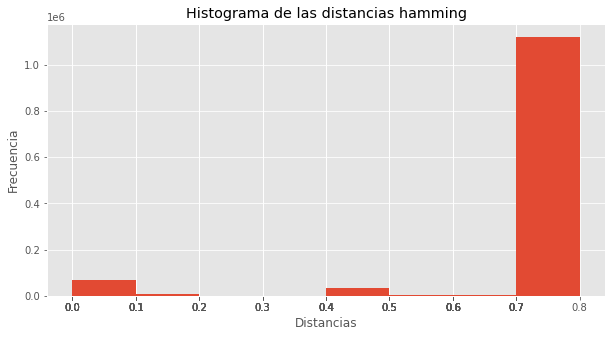

In [21]:
bins=np.around(np.unique(dist_condensada),1)
plt.figure(figsize=(10,5))
plt.hist(x=dist_condensada, bins=bins)
plt.title('Histograma de las distancias hamming')
plt.xlabel('Distancias')
plt.ylabel('Frecuencia')
plt.xticks(bins)
plt.show()

### Realizar el escalamiento multidimensional (MDS)

In [22]:
mds = MDS(n_components=10, max_iter=500, eps=1e-12,
                    dissimilarity="precomputed", random_state=0, n_jobs=-1,
                    n_init=15)
matriz_mds=mds.fit_transform(matriz_distancias)
print("Valor del stress al proyectar las secuencias genómicas SARS-CoV-2 a 10 dimensiones: ",mds.stress_)

Valor del stress al proyectar las secuencias genómicas SARS-CoV-2 a 10 dimensiones:  5273.093481566589


In [23]:
matriz_mds

array([[-0.00243834,  0.00558773, -0.16619811, ..., -0.40054009,
        -0.09758525,  0.10921529],
       [ 0.21566721, -0.26442435, -0.05363415, ...,  0.0204874 ,
         0.15513722,  0.175607  ],
       [ 0.35247143,  0.05932586, -0.18795312, ..., -0.06552432,
         0.23633255, -0.0016356 ],
       ...,
       [-0.00558286, -0.12277524,  0.10110446, ...,  0.26464992,
         0.23167608, -0.03892008],
       [ 0.21752564, -0.04907146,  0.1340805 , ..., -0.17280054,
         0.02565209, -0.19382826],
       [ 0.19270686, -0.04470819,  0.16561474, ..., -0.14487631,
         0.00360153, -0.13944498]])

### Realizar el análisis de componentes principales (PCA)

Tamaño de X_pca (1571, 10)


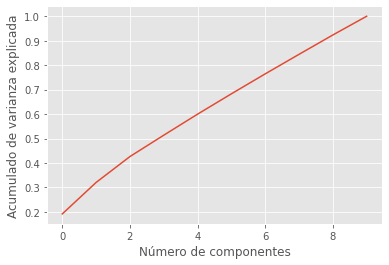

In [24]:
pca=PCA(.95) 
pca.fit(matriz_mds)
X_pca=pca.transform(matriz_mds) 
print("Tamaño de X_pca", X_pca.shape)
#Grafica del acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Acumulado de varianza explicada')
plt.show()

In [25]:
valor=np.cumsum(pca.explained_variance_ratio_[:2])[1]*100
print("Porcentaje de varianza explicada con los dos primeros componentes principales: ",round(valor, 2),"%")

Porcentaje de varianza explicada con los dos primeros componentes principales:  32.04 %


### Cálculo de los puntos de referencia (landmarks)

In [26]:
from sklearn.cluster import KMeans
n = 40
k_means = KMeans(init = "k-means++", n_clusters = n, n_init = 12).fit(X_pca)
centroides = k_means.cluster_centers_

In [27]:
listaIndices=[]
for a in range(len(centroides)):
    diferenciaTotal=0
    indice=0
    for i in range(len(X_pca)):
        fila=X_pca[i]
        diferencia=0
        for j in range(len(fila)):
            diferencia = diferencia+ abs(abs(fila[j])-abs(centroides[a][j]))
        if diferencia == 0:
            break
        elif diferencia>diferenciaTotal and not i in listaIndices:
            diferenciaTotal=diferencia
            indice=i
    listaIndices.append(indice)

### Calcular la matrix X e Y para entrenar la red neuronal

- Calcular la matrix X, datos de entrada

In [28]:
landmark=listaIndices
X = np.empty((0, n), int)
for i in range(len(matriz_distancias)):
    fila=[]
    #calcular la distancia de cada punto a los landmark
    for j in range(n):
        fila.append(matriz_distancias[i][landmark[j]])
    X = np.append(X, np.array([fila]), axis=0)
X

array([[0.74, 0.73, 0.71, ..., 0.75, 0.75, 0.72],
       [0.71, 0.72, 0.74, ..., 0.71, 0.71, 0.74],
       [0.71, 0.72, 0.74, ..., 0.71, 0.71, 0.74],
       ...,
       [0.72, 0.72, 0.75, ..., 0.72, 0.72, 0.74],
       [0.74, 0.74, 0.72, ..., 0.74, 0.74, 0.72],
       [0.73, 0.74, 0.72, ..., 0.74, 0.74, 0.71]])

- Calcular la matrix Y, datos de salida

In [29]:
Y = np.empty((len(X), 0), float)
for i in range(2):
    Y = np.append(Y, X_pca[:,i].reshape(-1, 1), axis=1)
Y

array([[-0.12020324, -0.27437072],
       [-0.01240376,  0.02520696],
       [-0.01052167,  0.02502493],
       ...,
       [-0.13767426,  0.39421958],
       [-0.11325186, -0.10026707],
       [-0.10970625, -0.15106827]])

### Red neuronal perceptrón multicapa (MLP)

- Crear red neuronal

In [32]:
# Funcion para definir el modelo MLP de 4 capas
def define_modelo_MLP():
    modelo = Sequential()  # Sequential indica que el modelo será una pila de capas conectadas secuencialmente (MLP) 
    modelo.add( Dense(n, kernel_initializer = keras.initializers.GlorotNormal(),input_shape=(n,), activation="tanh") ) # Define 1era capa oculta 
    modelo.add( Dense(20,kernel_initializer = keras.initializers.GlorotNormal(), activation="tanh") ) # Define 2da capa oculta 
    modelo.add( Dense(10,kernel_initializer = keras.initializers.GlorotNormal(), activation="tanh") ) # Define 3ra capa oculta 
    modelo.add( Dense(2, kernel_initializer = keras.initializers.GlorotNormal(),activation="tanh") ) # Define capa de salida con 2 neuronas (salidas) con activacion tangente
    # compila el modelo
    modelo.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.00009), loss='mean_squared_error', metrics=['mse'])
    return modelo

- Función para visualizar el gráfico de MSE Loss

In [33]:
def plot_learning_curves(histories):
    for i in range(len(histories)):
        # plotea la curva de loss
        plt.subplot(1, 1, 1)
        plt.title('MSE Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    plt.show()

- Entrenamiento de la red neuronal

In [36]:
modelo = define_modelo_MLP()
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=7)
history = modelo.fit(X_train, Y_train, epochs=3000, batch_size=32, validation_data=(X_test, Y_test), verbose=0)

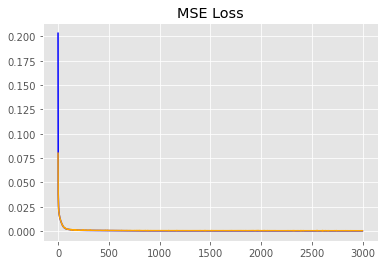

In [35]:
plot_learning_curves([history])

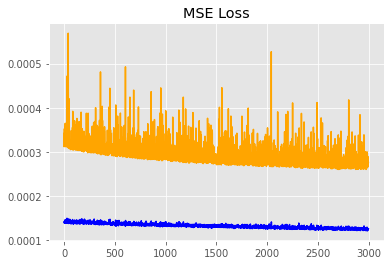

In [37]:
history = modelo.fit(X_train, Y_train, epochs=3000, batch_size=32, validation_data=(X_test, Y_test), verbose=0)
plot_learning_curves([history])

- Predicción de los valores de los datos de entrenamiento

In [113]:
valores=modelo.predict(X)
valores

array([[-0.06938261, -0.06373821],
       [-0.03355836,  0.00257665],
       [-0.08375931, -0.0661073 ],
       ...,
       [-0.18768373,  0.38431156],
       [-0.08202893, -0.11406501],
       [-0.07248888, -0.12168859]], dtype=float32)